# Data Science Case Study V1
**Description of the Data**
The dataset shared with you is an anonymized dataset of different properties in Dubai. The dataset contains the size, number of bedrooms, number of bathrooms, neighbourhood name, and building name and the listing price for different properties in Dubai. You can find the data under **data_science_challenge_data.csv**
**Assignment**
1.	Build a **Property Price Prediction Model**. Please use the Python programming language.
-	Explore the dataset, and share with us any insights that you may find which can help you create the price evaluation tool. Please summarise your findings in terms of the relationship between the different features, the price, and feature importance.
-	Build a model which predicts the listing price of the property based on the property’s features
    -	Model Input: Features of property
    -	Model Output: Predicted Price
-	How do you evaluate the quality of your results? 
-	What are the possible shortcoming & extensions of your approach?

2.	Build a **Property Price Valuation Tool**, which would take as input the features of a property and its listing price and determine whether the property is under-priced, fairly priced or overpriced. 
-	Implement a program to determine whether a property is underpriced, fairly priced or overpriced. This is your chance to show us the process that you would follow to solve this problem, and how you would model the data.
    -	Program Input: Property features and its price
    -	Program Output: Whether the prediction is  Underpriced, Fairly Priced, Overpriced
-	How do you evaluate the quality of your results? 
-	What are the possible shortcoming & extensions of your approach?

**Deliverables**  
Please share with us  
-	your program code  
-	a short presentation (10-15 slides) with the results of your work  

within one week. 

In [1]:
# Load the necessary libraries
import shap
import optuna
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.width', 2000)
shap.initjs()

---

# 1. Exploratory Data Analysis

### Let's load the data, look at main statistics, nulls, outliers etc

In [2]:
data = pd.read_csv('data_science_challenge_data.csv')
data.head()

neighbourhood     price    size  bedrooms  bathrooms      building
0           SNR  130000.0  1300.0         2        3.0  Building_263
1           ZMS  140000.0  1185.0         1        2.0   Building_25
2           ZMS  250000.0  2050.0         3        5.0  Building_324
3           ZMS  250000.0  3860.0         4        5.0  Building_353
4           SNR  170000.0  1896.0         3        4.0  Building_280

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67107 entries, 0 to 67106
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  67107 non-null  object 
 1   price          67107 non-null  float64
 2   size           67107 non-null  float64
 3   bedrooms       67107 non-null  int64  
 4   bathrooms      63657 non-null  float64
 5   building       61068 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.1+ MB


There are 67107 rows in dataset with 2 categorical features and 4 numerical ones. Note that *bathrooms* and *building* features has some missed values. Let's look at distribution of null in subset of dataset.

In [4]:
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title('Missed values analysis', fontsize=20)
sns.heatmap(data.sample(2000).isnull(), cmap=sns.color_palette(['blue', 'yellow']))
plt.show()

<img src="Pictures/missing_values_heatmap.PNG" width=1000 height=900 align="left"/>

It seems there is no correlation between nulls in last columns.

### Let's see the statistical description of values and plot distribution graphs.

In [6]:
data.describe(include='all')

neighbourhood         price          size      bedrooms     bathrooms      building
count          67107  6.710700e+04  6.710700e+04  67107.000000  63657.000000         61068
unique             3           NaN           NaN           NaN           NaN           353
top              ZMS           NaN           NaN           NaN           NaN  Building_101
freq           35833           NaN           NaN           NaN           NaN          1672
mean             NaN  2.199118e+05  1.621593e+03      1.654969      2.403066           NaN
std              NaN  5.882342e+06  9.049481e+03      1.008304      1.077319           NaN
min              NaN  2.200000e+04 -7.550000e+02      0.000000      1.000000           NaN
25%              NaN  9.900000e+04  8.400000e+02      1.000000      2.000000           NaN
50%              NaN  1.300000e+05  1.200000e+03      2.000000      2.000000           NaN
75%              NaN  1.650000e+05  1.637000e+03      2.000000      3.000000           NaN
max              NaN  5.653530e+08  1.170000e+06     12.000000     12.000000           NaN

Num_cols: 4
Cat_cols: 2


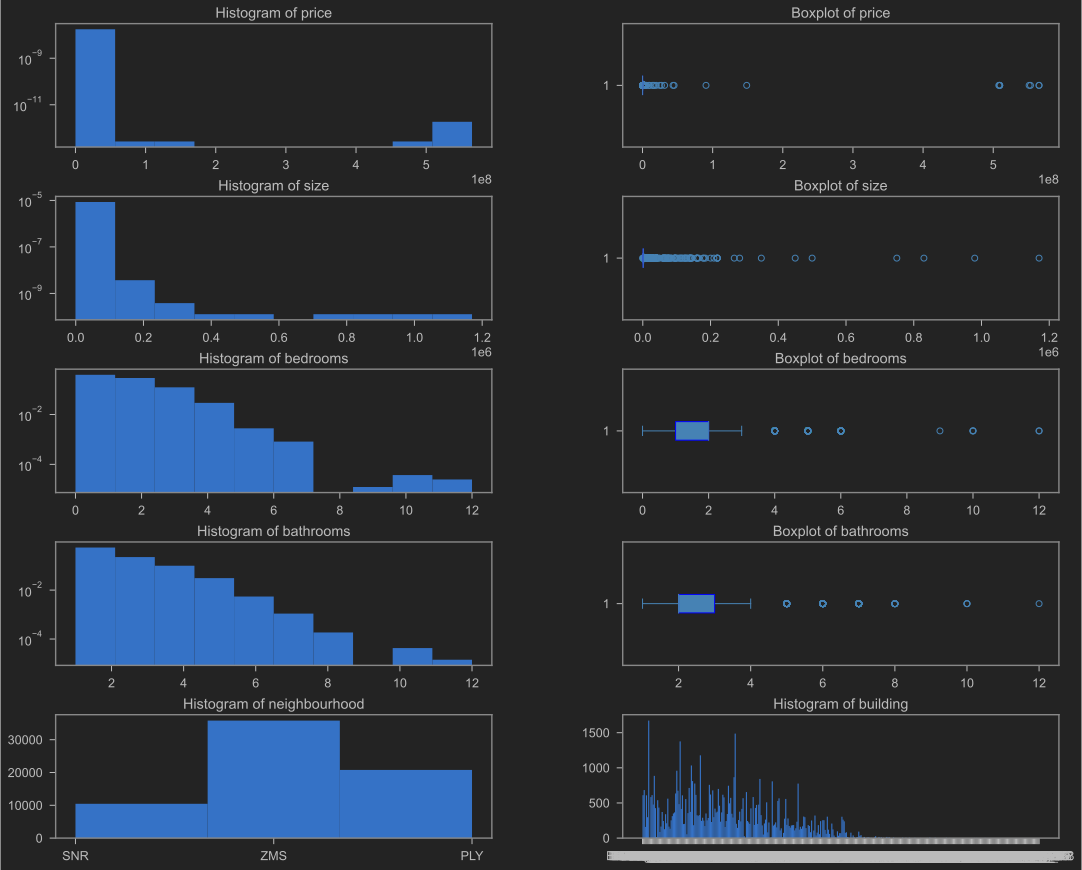

In [7]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
string_cols = data.select_dtypes(exclude=[np.number]).columns
print(f'Num_cols: {len(numeric_cols)}\nCat_cols: {len(string_cols)}')

rows_num = len(numeric_cols) + len(string_cols) // 2
fig, ax = plt.subplots(nrows=rows_num, ncols=2)
axes = ax.flatten()
i = 0

for col in numeric_cols:
    not_null_values = data.loc[~data[col].isnull(), col]     
    axes[i].hist(not_null_values, density=True, log=True)
    axes[i].set_title(f'Histogram of {col}')
    i += 1

    axes[i].boxplot(not_null_values, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', color='blue'),
                    capprops=dict(color='steelblue'),
                    whiskerprops=dict(color='steelblue'),
                    flierprops=dict(color='steelblue', markeredgecolor='steelblue'),
                    medianprops=dict(color='steelblue'),
                   )
    axes[i].set_title(f'Boxplot of {col}')
    i += 1
        
for col in string_cols:
    not_null_values = data.loc[~data[col].isnull(), col]
    
    axes[i].hist(not_null_values, histtype='bar', bins=len(not_null_values.unique()))
    axes[i].set_title(f'Histogram of {col}')
    i += 1
    
fig.set_size_inches(18, 3 * (len(numeric_cols) - 1 + len(string_cols)))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

<img src="Pictures/features_histogramm.PNG" width=1400 height=1800 align="left"/>

- All numerical features have a skewed distributions.  
- There is extremely high price values. Some high values in prices are correlated with a high size and large amount of bedrooms/bathrooms (need to check, could bee outliers).
- Negative size is unreal value (outliers).
- There are 3 neighbourhoods but the most frequent is ZMS.
- There are 353 buildings with different frequency. It looks like distribution of building with different floors amount.

### Check the correlation between values

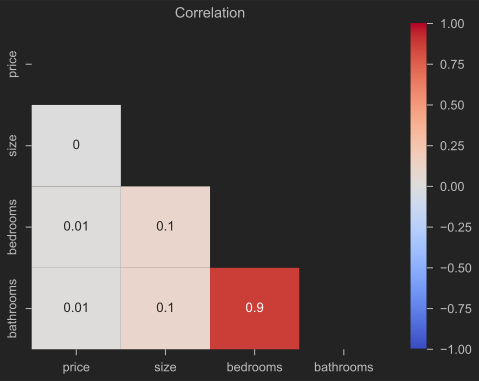

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(round(data.corr(), 2), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=np.triu(data.corr()))
plt.title('Correlation')
plt.show()

<img src="Pictures/features_correlation.PNG" width=600 height=600 align="left"/>

In [ ]:
sns.pairplot(data.sample(500), diag_kind='kde')
plt.show()

<img src="Pictures/features_pairplot.PNG" width=900 height=900 align="left"/>

High correlation between bathrooms and bedrooms can be connected with master-bedrooms, when each bedrooms contain a bathroom (use it to fill nulls). Low correlation between price and other regressors looks weird and could be connected with price outliers, lets check it on plot PRICE = f(SIZE, ROOMS, REGION).

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='size', y='price', hue='bedrooms', style='neighbourhood', palette="coolwarm", alpha=.7).set(xscale="log", yscale="log")
plt.show()

<img src="Pictures/base_features_total_plot.PNG" width=800 height=800 align="left"/>

- There are few clouds of points with trends depending on size and rooms amount.
- Neighbourhood doesn't highly affects on price.
- There are outliers in size (low values) and in price (high values).

In [ ]:
# Check cat. features with price
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.kdeplot(data=data, x='price', hue='neighbourhood', fill=True, alpha=.4, log_scale=True)
plt.subplot(122)
sns.kdeplot(data=data.groupby('building').agg(building_counts=('building', pd.value_counts), median_price=('price', np.median)),
         y='building_counts', x='median_price', fill=True, log_scale=True)
plt.show()

<img src="Pictures/price_dependencies.PNG" width=1400 height=800 align="left"/>

There is some differentiation by price in PLY and SNR regions and some weak splitting in price depending on buidling counts (suggests that it correlates with floors amount)

### NULLs filling

The correlation matrix above showed the relationship between *bedrooms* and *bathrooms*, hence fill missing *bathrooms* out *bedrooms* using median values (median is more stable to high/low values that mean)

In [ ]:
plt.figure(figsize=(18, 5))
sns.boxplot(x=data['bedrooms'], y=data['bathrooms'], flierprops=dict(markerfacecolor="#808080"))
plt.show()

<img src="Pictures/bathrooms_bedrooms_boxplot.PNG" width=1400 height=800 align="left"/>

In [13]:
# Create bathrooms fillna dataframe. Note that there is no values of bathrooms coresponds to 9-rooms of bedrooms. Hence, take around value - 6 (like for 5, 6 and 10 bedrooms)
bathrooms_fillna_df = data.groupby('bedrooms').agg(bathrooms_median=('bathrooms', np.median)).fillna(method='ffill').reset_index()
data = pd.merge(data, bathrooms_fillna_df, how='left', on='bedrooms')
data['bathrooms'].fillna(data['bathrooms_median'], inplace=True)
data.drop(columns='bathrooms_median', inplace=True)

In [14]:
# Optimize columns type
data['bedrooms'] = data['bedrooms'].astype('int8')
data['bathrooms'] = data['bathrooms'].astype('int8')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67107 entries, 0 to 67106
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  67107 non-null  object 
 1   price          67107 non-null  float64
 2   size           67107 non-null  float64
 3   bedrooms       67107 non-null  int8   
 4   bathrooms      67107 non-null  int8   
 5   building       61068 non-null  object 
dtypes: float64(2), int8(2), object(2)
memory usage: 2.7+ MB


In [15]:
# For building missing use most frequent building number in each neighbourhood for each bathrooms number
building_fillna_df = data.groupby(['neighbourhood', 'bathrooms']).agg(most_frequent_building=('building', lambda x: x.value_counts().index[0])).reset_index()
data = pd.merge(data, building_fillna_df, how='left', on=['neighbourhood', 'bathrooms'])
data['building'].fillna(data['most_frequent_building'], inplace=True)
data.drop(columns='most_frequent_building', inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67107 entries, 0 to 67106
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  67107 non-null  object 
 1   price          67107 non-null  float64
 2   size           67107 non-null  float64
 3   bedrooms       67107 non-null  int8   
 4   bathrooms      67107 non-null  int8   
 5   building       67107 non-null  object 
dtypes: float64(2), int8(2), object(2)
memory usage: 2.7+ MB


### Outliers processing

In [17]:
median_size_in_building = data.groupby('building').agg(median_size_in_building=('size', np.median)).reset_index()
data = pd.merge(data, median_size_in_building, how='left', on='building')
data.loc[data['size']<10, 'size'] = data['median_size_in_building']

In [18]:
median_price_in_building = data.groupby('building').agg(median_price_in_building=('price', np.median)).reset_index()
data = pd.merge(data, median_price_in_building, how='left', on='building')
data.loc[data['price']>0.8e7, 'price'] = data['median_price_in_building']

In [19]:
data.describe(include='all')

neighbourhood         price          size      bedrooms     bathrooms      building  median_size_in_building  median_price_in_building
count          67107  6.710700e+04  6.710700e+04  67107.000000  67107.000000         67107             67107.000000              6.710700e+04
unique             3           NaN           NaN           NaN           NaN           353                      NaN                       NaN
top              ZMS           NaN           NaN           NaN           NaN  Building_101                      NaN                       NaN
freq           35833           NaN           NaN           NaN           NaN          3594                      NaN                       NaN
mean             NaN  1.489418e+05  1.622999e+03      1.654969      2.416469           NaN              1265.563758              1.369268e+05
std              NaN  1.313259e+05  9.049332e+03      1.008304      1.074550           NaN               683.242480              6.709422e+04
min              NaN  2.200000e+04  3.800000e+01      0.000000      1.000000           NaN               385.000000              4.400000e+04
25%              NaN  9.900000e+04  8.400000e+02      1.000000      2.000000           NaN               860.000000              9.900000e+04
50%              NaN  1.300000e+05  1.200000e+03      2.000000      2.000000           NaN              1135.000000              1.270000e+05
75%              NaN  1.650000e+05  1.638500e+03      2.000000      3.000000           NaN              1393.000000              1.500000e+05
max              NaN  5.770000e+06  1.170000e+06     12.000000     12.000000           NaN             11314.000000              1.067974e+06

---

# 2. Baseline Model

In [20]:
lr = LinearRegression()
scaler = StandardScaler()

# Choose regressors and target, normalize regressors
X_train_data = pd.get_dummies(data.drop(columns=['price', 'median_size_in_building', 'median_price_in_building']))
X_train_data = scaler.fit_transform(X_train_data)
y_train_data = data['price']

# Run baseline with KFold cross-validation
kf = KFold(n_splits=5, random_state=128, shuffle=False)
for train_index, test_index in kf.split(X_train_data):
    X_train, X_test = X_train_data[train_index], X_train_data[test_index]
    y_train, y_test = y_train_data[train_index], y_train_data[test_index]
    baseline_model = lr.fit(X_train, y_train)
    print(f'Train: {baseline_model.score(X_train, y_train)}, Valid: {baseline_model.score(X_test, y_test)}')

Train: 0.3547808030826392, Valid: -1.1968951460105131e+27
Train: 0.3462804866927746, Valid: -1.0031344593718527e+28
Train: 0.34929392876668763, Valid: -4.973288248379924e+26
Train: 0.3582387986677622, Valid: -8.225591117497716e+26
Train: 0.36144250480753337, Valid: -1.1177507657292753e+26


In [ ]:
# Plot the last model
sns.scatterplot(x=baseline_model.predict(X_train), y=y_train.values).set(xscale="log", yscale="log")
sns.scatterplot(x=baseline_model.predict(X_test), y=y_test.values).set(xscale="log", yscale="log")
plt.legend(labels=['Train', 'Test'])
plt.show()

<img src="Pictures/Baseline_plot.PNG" width=700 height=700 align="left"/>

Baseline model has very low metric (R2~0.35 on train) and predicts some abnormal values (suggest unseen building data due to the feature has a lot of categories, including unique ones).  
Let's try to improve the model.

---

# 3. New Features generation

In [22]:
# median_size_in_building and median_price_in_building have been created in EDA part

# Add numerical building features (building frequency)
building_count = data['building'].value_counts().reset_index().set_axis(['building', 'building_count'], axis=1)
data = pd.merge(data, building_count, how='left', on='building')

# Add numerical building features (building frequency) but grouped by neighbourhood
building_count_in_region = data.groupby(['neighbourhood', 'building']).agg(building_count_in_region=('building', pd.Series.value_counts)).reset_index()
data = pd.merge(data, building_count_in_region, how='left', on=['neighbourhood', 'building'])
    
# Add total rooms amount
data['total_rooms'] = data['bathrooms'] + data['bedrooms']

# Add average room size
data['average_room_size'] = data['size'] / data['total_rooms']

# Add target-like features: median price in buildings and neighbourhoods
data['price_per_meter'] = data['price'] / data['size']

median_meter_price_in_building = data.groupby('building').agg(median_meter_price_in_building=('price_per_meter', np.median)).reset_index()
data = pd.merge(data, median_meter_price_in_building, how='left', on='building')
    
median_meter_price_in_region = data.groupby('neighbourhood').agg(median_meter_price_in_region=('price_per_meter', np.median)).reset_index()
data = pd.merge(data, median_meter_price_in_region, how='left', on='neighbourhood')

data.drop(columns='price_per_meter', inplace=True)

In [23]:
def sqr_sqrt_log_features_transform(data: pd.DataFrame,
                                    sqr_miss: list=None,
                                    sqrt_miss: list=None,
                                    log_miss: list=None,
                                   ) -> pd.DataFrame:
    """
    Function transforms dataset adding squares, square roots and logarithm of numerical features
    
    :param df:  input data frame
    :sqr_miss:  columns, that should be missed for square feature generation
    :sqrt_miss: columns, that should be missed for square root feature generation
    :log_miss:  columns, that should be missed for logarithm feature generation
    
    :return:    dataframe with added features
    """
    
    df = data.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if ~np.isin(col, sqr_miss):
            df[f'{col}_sqr'] = df[col]**2
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqrt'] = np.sqrt(df[col])
        if ~np.isin(col, log_miss):
            df[f'{col}_log'] = np.log(df[col] + 0.01)
        
    return df

In [24]:
data = sqr_sqrt_log_features_transform(data, 
                                       sqr_miss=['price', 'size', 'median_price_in_building', 'median_size_in_building', 'median_meter_price_in_building', 'median_meter_price_in_region'],
                                       sqrt_miss=['price'],
                                       log_miss=['price'],
                                      )
data.shape

(67107, 42)

In [25]:
# Choose regressors and target, normalize regressors
X_train_data = pd.get_dummies(data.drop(columns=['price', 'building']))
feature_cols = X_train_data.columns
X_train_data = scaler.fit_transform(X_train_data)
y_train_data = data['price']

# Check the difference between Model with new features and Baseline
kf = KFold(n_splits=5, random_state=128, shuffle=True)
for train_index, test_index in kf.split(X_train_data):
    X_train, X_test = X_train_data[train_index], X_train_data[test_index]
    y_train, y_test = y_train_data[train_index], y_train_data[test_index]
    model = lr.fit(X_train, y_train)
    
    print(f'Train: {model.score(X_train, y_train)}, Test: {model.score(X_test, y_test)}')

Train: 0.48914801331512126, Test: 0.5300813081176277
Train: 0.5492713448286033, Test: 0.2616552009918627
Train: 0.47701345709661425, Test: 0.5869775295355978
Train: 0.5133948659275545, Test: 0.445461838030876
Train: 0.4823504696364054, Test: -2.353219377155659


New features improve the model quality but there is some overfitting, hence regularization should be used

---

# 4. Feature selection

### NOTE: 
In order to check feature importance two types of models have been used: linear model and gradient boosting tree. Boosting type models almost always showed better quality but they are restricted by trained data values range. It means that appearance of a new value (of any feature) outside the previous range will cause constant value prediction. This could be critical for task uder consideration. Linear models don't have such restriction, that's why there are two types of models will be considered further. GB model will be used for price prediction on the data like in existing data set and LR model will be used for new kind of data (for example, new building or new amount of rooms which is higher than in data set).

### Linear type model

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=128)

model = lr.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_valid, y_valid)

(0.4891479065327712, 0.5300827925217224)

In [27]:
# top features
importance = permutation_importance(model, X_valid, y_valid, scoring='r2', n_jobs=-1, random_state=128)
importance_scores = pd.DataFrame({"features": feature_cols,
                                  "importance-mean": importance.importances_mean,
                                  "importance-std": importance.importances_std})
importance_scores = importance_scores.sort_values(by="importance-mean", ascending=False).reset_index(drop=True)
importance_scores

features  importance-mean  importance-std
0     median_meter_price_in_region_sqrt     3.057573e+21    2.242323e+19
1                     neighbourhood_ZMS     1.992331e+21    1.395739e+19
2                     neighbourhood_SNR     4.913383e+20    2.186494e+18
3          median_meter_price_in_region     2.304428e+20    1.688370e+18
4                     neighbourhood_PLY     1.479609e+20    1.389240e+18
5      median_meter_price_in_region_log     3.498433e+19    2.568114e+17
6                           total_rooms     3.865485e+18    2.459244e+16
7                             bathrooms     1.103871e+18    4.935465e+15
8                              bedrooms     9.650308e+17    8.135978e+15
9                       total_rooms_log     1.046175e+06    8.789057e+03
10                             size_log     9.600504e+05    5.614614e+03
11                average_room_size_log     3.344090e+05    3.954002e+03
12                     total_rooms_sqrt     1.409712e+03    1.048615e+01
13                       bathrooms_sqrt     5.670561e+02    2.891542e+00
14                        bathrooms_log     1.369265e+02    9.068556e-01
15         median_size_in_building_sqrt     1.949368e+01    1.779559e-01
16                       building_count     1.709952e+01    9.723811e-02
17             building_count_in_region     1.519494e+01    8.969443e-02
18              median_size_in_building     7.069805e+00    7.248145e-02
19                  building_count_sqrt     6.013189e+00    2.837609e-02
20        building_count_in_region_sqrt     5.993227e+00    1.729578e-02
21  median_meter_price_in_building_sqrt     5.957678e+00    5.182309e-02
22          median_size_in_building_log     4.342573e+00    2.709069e-02
23                   building_count_sqr     3.884566e+00    2.841477e-02
24                            size_sqrt     3.861617e+00    3.321460e-02
25        median_price_in_building_sqrt     3.762251e+00    3.685048e-02
26         building_count_in_region_sqr     3.256918e+00    2.702398e-02
27   median_meter_price_in_building_log     2.627075e+00    2.045772e-02
28               average_room_size_sqrt     2.461509e+00    1.691204e-02
29                        bedrooms_sqrt     1.661427e+00    2.006797e-02
30                    average_room_size     1.441951e+00    3.456291e-03
31                                 size     1.177423e+00    1.285071e-03
32       median_meter_price_in_building     1.112821e+00    8.434439e-03
33             median_price_in_building     1.093846e+00    1.185074e-02
34         median_price_in_building_log     6.877983e-01    6.769914e-03
35                      total_rooms_sqr     4.575323e-01    7.943383e-03
36                        bathrooms_sqr     3.779968e-01    4.156267e-03
37         building_count_in_region_log     1.259118e-01    3.087395e-03
38                         bedrooms_sqr     1.212999e-01    2.098558e-03
39                         bedrooms_log     1.153998e-01    2.256832e-03
40                   building_count_log     7.150182e-02    1.648744e-03
41                average_room_size_sqr     6.301779e-03    4.926858e-04

In [ ]:
def show_feature_importances(feature_names, feature_importances):
    """
    Function for feature importance plot
    
    :param feature_names: Name of using features
    :param feature_importances: Importances of features
    
    :return: None
    """
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)      
    plt.figure(figsize = (10, len(feature_importances) * 0.355))   
    sns.barplot(feature_importances['importance'], feature_importances['feature']).set(xscale="log")  
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()    
    
show_feature_importances(importance_scores['features'], importance_scores['importance-mean'])

<img src="Pictures/LRM_feat_imp.PNG" width=1000 height=2000 align="left"/>

All features have a positive weight, so all features are important for LR model. Never the less, some bottom features could be removed from model to make it easier.  

### Gradient Boosting type model

In [28]:
# Choose regressors and target, normalize regressors
X_train_data = data.drop(columns=['price', 'building'])
y_train_data = data['price']

# Make hold-out validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=128)

string_cols = X_train.select_dtypes(exclude=[np.number]).columns
X_train[string_cols] = X_train[string_cols].astype('category')
X_valid[string_cols] = X_valid[string_cols].astype('category')

# Let's use fastest GB model at this step
lgb_params = {"n_estimators": 500,
               "max_depth": 5,
               "n_jobs": -1,
               "random_state": 128,
              }

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train,
              early_stopping_rounds=50, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10)

r2_score(y_train, lgb_model.predict(X_train)), r2_score(y_valid, lgb_model.predict(X_valid))

[10]	training's l2: 9.11687e+09	valid_1's l2: 6.80786e+09
[20]	training's l2: 7.83085e+09	valid_1's l2: 5.48693e+09
[30]	training's l2: 7.4285e+09	valid_1's l2: 5.17761e+09
[40]	training's l2: 7.28839e+09	valid_1's l2: 5.1469e+09
[50]	training's l2: 7.21554e+09	valid_1's l2: 5.16583e+09
[60]	training's l2: 7.1619e+09	valid_1's l2: 5.17424e+09
[70]	training's l2: 7.12073e+09	valid_1's l2: 5.17589e+09
[80]	training's l2: 7.08052e+09	valid_1's l2: 5.17525e+09


(0.5868621299412629, 0.6613355520711869)

In [ ]:
# Look at top features for boosting type model
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, axis_color='#808080')

<img src="Pictures/Shap_GBM_feat_imp.PNG" width=800 height=800 align="left"/>

In [30]:
feature_names = X_valid.columns
shap_df = pd.DataFrame(shap_values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, ignore_index=True, inplace=True)
shap_importance

col_name  feature_importance_vals
0                                  size             27844.329206
1                          bedrooms_sqr             11392.446190
2              median_price_in_building             11025.927495
3        median_meter_price_in_building              6523.879202
4                       total_rooms_sqr              3775.849196
5                              bedrooms              1365.649306
6                           total_rooms              1238.816298
7               median_size_in_building              1232.474627
8                     average_room_size              1030.023438
9                             bathrooms               538.509504
10                       building_count               451.949196
11                        neighbourhood               294.981517
12             building_count_in_region                91.374716
13         building_count_in_region_log                 0.000000
14        building_count_in_region_sqrt                 0.000000
15                      total_rooms_log                 0.000000
16                     total_rooms_sqrt                 0.000000
17   median_meter_price_in_building_log                 0.000000
18                average_room_size_sqr                 0.000000
19               average_room_size_sqrt                 0.000000
20                average_room_size_log                 0.000000
21  median_meter_price_in_building_sqrt                 0.000000
22                   building_count_log                 0.000000
23    median_meter_price_in_region_sqrt                 0.000000
24         building_count_in_region_sqr                 0.000000
25         median_size_in_building_sqrt                 0.000000
26                  building_count_sqrt                 0.000000
27                   building_count_sqr                 0.000000
28         median_price_in_building_log                 0.000000
29        median_price_in_building_sqrt                 0.000000
30          median_size_in_building_log                 0.000000
31                        bathrooms_log                 0.000000
32                       bathrooms_sqrt                 0.000000
33                        bathrooms_sqr                 0.000000
34                         bedrooms_log                 0.000000
35                        bedrooms_sqrt                 0.000000
36                             size_log                 0.000000
37                            size_sqrt                 0.000000
38         median_meter_price_in_region                 0.000000
39     median_meter_price_in_region_log                 0.000000

Much lower features is needed for GB model and the model showed better result that LR model. So left only important features for GB model.

In [31]:
GBM_features = shap_importance.loc[shap_importance['feature_importance_vals']>0, :]
GBM_features

col_name  feature_importance_vals
0                             size             27844.329206
1                     bedrooms_sqr             11392.446190
2         median_price_in_building             11025.927495
3   median_meter_price_in_building              6523.879202
4                  total_rooms_sqr              3775.849196
5                         bedrooms              1365.649306
6                      total_rooms              1238.816298
7          median_size_in_building              1232.474627
8                average_room_size              1030.023438
9                        bathrooms               538.509504
10                  building_count               451.949196
11                   neighbourhood               294.981517
12        building_count_in_region                91.374716

---

# 5. Model Selection and hyperparameters tuning

To choose the best model and best hyperparameters Optuna was used. As it was mentioned above optimal models and params will be choose for both linear type model and for gradient boosting type model in order to predict price for defferent situations.

### Linear models

In [32]:
# Put baseline here
X_train_data = pd.get_dummies(data.drop(columns=['price', 'building']))
X_train_data = scaler.fit_transform(X_train_data)
y_train_data = data['price']

lr = LinearRegression()
score = cross_val_score(lr, X_train_data, y_train_data, n_jobs=-1, cv=5)
print(f'CV_scores: {score}\nMean_score: {score.mean(0)}')

CV_scores: [ 0.50842459  0.50770082  0.57835202  0.35373011 -1.40473031]
Mean_score: 0.10869544621484213


In [33]:
def objective(trial):
    """
    Optuna function for parameters tunning that returns score at each trial
    """
    
    lr_model_name = trial.suggest_categorical('regressor', ['Lasso', 'Ridge', 'ElasticNet'])

    if lr_model_name == 'Lasso':
        alpha = trial.suggest_float("alpha", 0.1, 10)
        lr_model_obj = Lasso(alpha=alpha) 
    elif lr_model_name == 'Ridge':
        alpha = trial.suggest_float("alpha", 0.1, 10)
        lr_model_obj = Ridge(alpha=alpha) 
    else:
        alpha = trial.suggest_float("alpha", 0.1, 10)
        l1_ratio = trial.suggest_float("l1_ratio", 0.1, 0.9)
        lr_model_obj = ElasticNet(alpha=alpha, l1_ratio=l1_ratio) 
    
    score = cross_val_score(lr_model_obj, X_train_data, y_train_data, n_jobs=-1, cv=5)
    
    return score.mean(0)

In [ ]:
lr_study = optuna.create_study(direction="maximize")
lr_study.optimize(objective, n_trials=100)

In [35]:
print("Number of finished trials: {}".format(len(lr_study.trials)))
print("Best trial:")
trial_full = lr_study.best_trial
print("  Value: {}".format(trial_full.value))
print("  Params: ")
for key, value in trial_full.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.4721069739753574
  Params: 
    regressor: ElasticNet
    alpha: 0.1287250543864751
    l1_ratio: 0.8392661190813218


In [36]:
# Check the best model
lr_model = ElasticNet(alpha=lr_study.best_trial.params['alpha'], l1_ratio=lr_study.best_trial.params['l1_ratio'])
score = cross_val_score(lr_model, X_train_data, y_train_data, n_jobs=-1, cv=5)
print(f'CV_scores: {score}\nMean_score: {score.mean(0)}')

CV_scores: [0.50105775 0.50010835 0.55479198 0.41674099 0.38783579]
Mean_score: 0.4721069739753574


In [84]:
X_train_data = pd.get_dummies(data.drop(columns=['price', 'building']))
X_train_data = scaler.fit_transform(X_train_data)
y_train_data = data['price']
X_train, X_valid, y_train, y_valid = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=128)
lr_model.fit(X_train, y_train)
lr_std = np.sqrt(mean_squared_error(y_train, lr_model.predict(X_train)))
lr_predict = lr_model.predict(X_valid)
r2_score(y_valid, lr_predict)

0.5424537200127975

In [ ]:
# Plot the last model
sns.scatterplot(x=lr_model.predict(X_train), y=y_train.values).set(xscale="log", yscale="log")
sns.scatterplot(x=lr_model.predict(X_valid), y=y_valid.values).set(xscale="log", yscale="log")
plt.plot([1e3, 1e7], [1e3, 1e7], 'red', linewidth=2)
plt.legend(labels=['Equilibrium', 'Train', 'Test'])
plt.show()

<img src="Pictures/lr_plot.PNG" width=600 height=600 align="left"/>

### Gradient Boosting models

In [62]:
# Select only important features for GB models
X_train_data = pd.get_dummies(data.drop(columns=['price', 'building'])[GBM_features['col_name'].values])
y_train_data = data['price']
X_train, X_valid, y_train, y_valid = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=128)

In [38]:
def objective(trial):
    """
    Optuna function for parameters tunning that returns score at each trial
    """
    
    gb_model_name = trial.suggest_categorical('regressor', ['lgbm', 'xgbm', 'cbm'])

    if gb_model_name == 'lgbm':
        lgb_params = {"n_estimators": 500,
                      "device": 'gpu',
                      "random_state": 128,
                      # Tunning
                      "max_depth": trial.suggest_int("max_depth", 4, 10),
                      "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 30),
                      "min_sum_hessian_per_leaf": trial.suggest_float("min_sum_hessian_per_leaf", 0.001, 0.01),
                      "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1.0),
                      "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.),
                      "reg_alpha": trial.suggest_float("reg_alpha", 0., 5.),
                      "min_data_per_group": trial.suggest_int("min_data_per_group", 30, 200),
                      "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.),
                      "num_leaves": trial.suggest_int("num_leaves", 20, 50),
                     }
        gb_model_obj = lgb.LGBMRegressor(**lgb_params) 
    elif gb_model_name == 'xgbm':
        xgb_params = {"n_estimators": 500,
                      "tree_method": 'gpu_hist',
                      "random_state": 128,
                      # Tunning
                      "max_depth": trial.suggest_int("max_depth", 4, 10),
                      "colsample_bytree": trial.suggest_float("feature_fraction", 0.8, 1.0),
                      "colsample_bylevel": trial.suggest_float("feature_fraction", 0.8, 1.0),
                      "colsample_bynode": trial.suggest_float("feature_fraction", 0.8, 1.0),
                      "subsample": trial.suggest_float("feature_fraction", 0.8, 1.0),
                      "min_child_weight": trial.suggest_float("min_sum_hessian_per_leaf", 0.001, 0.01),
                      "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.),
                      "reg_alpha": trial.suggest_float("reg_alpha", 0., 5.),
                      "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.),
                     }
        gb_model_obj = xgb.XGBRegressor(**xgb_params)  
    else:
        cb_params = {"n_estimators": 500,
                     "task_type": "GPU",
                     "random_state": 128,
                     # Tunning
                     "max_depth": trial.suggest_int("max_depth", 4, 10),
                     "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.),
                     "min_data_in_leaf": trial.suggest_int("min_data_per_group", 30, 200),
                     "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.),
                    }
        gb_model_obj = cb.CatBoostRegressor(**cb_params)  
    
#     score = cross_val_score(gb_model_obj, X_train_data, y_train_data, n_jobs=-1, cv=5, scoring='r2')
    gb_model_obj.fit(X_train, y_train,
                 early_stopping_rounds=50, 
                 eval_set=[(X_valid, y_valid)],
                 verbose=10)
    
    return r2_score(y_valid, gb_model_obj.predict(X_valid))

In [ ]:
gbm_study = optuna.create_study(direction="maximize")
gbm_study.optimize(objective, n_trials=60)

In [40]:
print("Number of finished trials: {}".format(len(gbm_study.trials)))
print("Best trial:")
trial_full = gbm_study.best_trial
print("  Value: {}".format(trial_full.value))
print("  Params: ")
for key, value in trial_full.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 60
Best trial:
  Value: 0.669049901705314
  Params: 
    regressor: lgbm
    max_depth: 7
    min_samples_leaf: 25
    min_sum_hessian_per_leaf: 0.003954744455595793
    feature_fraction: 0.919740201982652
    reg_lambda: 1.860974465763909
    reg_alpha: 0.8487326858562804
    min_data_per_group: 84
    learning_rate: 0.019365421141901363
    num_leaves: 50


In [93]:
lgb_params = {"n_estimators": 500,
              "device": 'gpu',
              "random_state": 128,
             }
lgb_params.update(trial_full.params)
del lgb_params['regressor']

In [90]:
gb_model_obj = lgb.LGBMRegressor(**lgb_params) 
gb_model_obj.fit(X_train, y_train,
                 early_stopping_rounds=50, 
                 eval_set=[(X_valid, y_valid)],
                 verbose=0)
gb_std = np.sqrt(mean_squared_error(y_train, gb_model_obj.predict(X_train)))
gb_predict = gb_model_obj.predict(X_valid)
r2_score(y_valid, gb_predict)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.003954744455595793 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] feature_fraction is set=0.919740201982652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.919740201982652


0.6669109696882423

In [ ]:
# Plot the last model
sns.scatterplot(x=gb_model_obj.predict(X_train), y=y_train.values).set(xscale="log", yscale="log")
sns.scatterplot(x=gb_model_obj.predict(X_valid), y=y_valid.values).set(xscale="log", yscale="log")
plt.plot([1e3, 1e7], [1e3, 1e7], 'red', linewidth=2)
plt.legend(labels=['Equilibrium', 'Train', 'Test'])
plt.show()

<img src="Pictures/gb_plot.PNG" width=600 height=600 align="left"/>

---

# 6. Property Price Valuation Tool

To estimate the expensiveness the standart deviation from average (predicted) cost was used. The suggested method compares a current price with an average (predicted) price and summarize whether current price in range average (predicted) price +/- one standart deviation or not:  
- FAIRLY PRICED: pred_price - stand_dev <= current_price <= pred_price + stand_dev  
- UNDERPRICED: current_price < pred_price - stand_dev
- OVERPRICED: current_price > pred_price + stand_dev

In [82]:
def property_price_valuation_tool(predicted_prices: np.ndarray,
                                  actual_prices: np.ndarray,
                                  std: float,
                                 ) -> pd.DataFrame:
    """
    Function estimated the quality of price (overpriced, underpriced, fairly priced)
    
    :param predicted_prices: prices predicted by the model
    :param actual_prices:    actual prices
    :param std:              standart deviation of trained model
    
    :return:                 data frame with predicted and actual prices and evaluation of expensivness
    """
    price_evaluation = pd.DataFrame({'Average_price': predicted_prices, 'Actual_price': actual_prices}).reset_index(drop=True)
    price_evaluation['Price_evaluation'] = np.where(price_evaluation['Actual_price'] > price_evaluation['Average_price'] + std,
                                                    'Overpriced',
                                                    np.where(price_evaluation['Actual_price'] < price_evaluation['Average_price'] - std,
                                                             'Underpriced',
                                                             'Fairly priced',
                                                            ),
                                                   )
    print(price_evaluation['Price_evaluation'].value_counts())
    
    return price_evaluation

In [83]:
property_price_valuation_tool(gb_predict, y_valid.values, gb_std)

Fairly priced    13227
Overpriced         133
Underpriced         62
Name: Price_evaluation, dtype: int64


Average_price  Actual_price Price_evaluation
0      177643.484448      150000.0    Fairly priced
1      253206.146399      248000.0    Fairly priced
2      211992.984282      225000.0    Fairly priced
3      101707.581774       88000.0    Fairly priced
4       92607.674878       90000.0    Fairly priced
...              ...           ...              ...
13417  216649.520777      215000.0    Fairly priced
13418   75799.288879       77000.0    Fairly priced
13419  176451.492705      175000.0    Fairly priced
13420  145703.608000      140000.0    Fairly priced
13421   78428.369676       68000.0    Fairly priced

[13422 rows x 3 columns]